CHATBOT WITH TOOLS AND MEMORY - Bit Like an Agent

In [1]:
from dotenv import load_dotenv
load_dotenv('.env')	
import os

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

In [3]:
base_url = "http://localhost:11434/"


llm= ChatOllama(
    base_url=base_url,
    model='llama3.2',
    temperature=0.9
)

In [4]:
@tool
def webSearch(prompt: str) -> str:
    """
    Search the web for the realtime and latest information on the given prompt.
    for example, news, articles, blogs, stock market, etc.

    Args:
        prompt: The prompt to search for.
    """
    search = TavilySearchResults(
        max_results=3,
        search_depth='advanced',
        include_answer=True,
        include_raw_content=True,
    )
    response = search.invoke(prompt)
    
    return response

# print(webSearch('Who is the current president of the United States?'))
# search.invoke('Who is the president of the United States?')

In [5]:
@tool
def llmSearch(prompt: str) -> str:
    """
    Use the LLM model for general queries and basic information.
    """
    # message = HumanMessage(prompt)
    response = llm.invoke(prompt)
    return response

In [6]:
webSearch

StructuredTool(name='webSearch', description='Search the web for the realtime and latest information on the given prompt.\nfor example, news, articles, blogs, stock market, etc.\n\nArgs:\n    prompt: The prompt to search for.', args_schema=<class 'langchain_core.utils.pydantic.webSearch'>, func=<function webSearch at 0x0000012A4FA4BEC0>)

In [7]:
llmSearch

StructuredTool(name='llmSearch', description='Use the LLM model for general queries and basic information.', args_schema=<class 'langchain_core.utils.pydantic.llmSearch'>, func=<function llmSearch at 0x0000012A4FBDA5C0>)

In [8]:
tools = [webSearch, llmSearch]
tools

[StructuredTool(name='webSearch', description='Search the web for the realtime and latest information on the given prompt.\nfor example, news, articles, blogs, stock market, etc.\n\nArgs:\n    prompt: The prompt to search for.', args_schema=<class 'langchain_core.utils.pydantic.webSearch'>, func=<function webSearch at 0x0000012A4FA4BEC0>),
 StructuredTool(name='llmSearch', description='Use the LLM model for general queries and basic information.', args_schema=<class 'langchain_core.utils.pydantic.llmSearch'>, func=<function llmSearch at 0x0000012A4FBDA5C0>)]

In [9]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.2', temperature=0.9, base_url='http://localhost:11434/'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'webSearch', 'description': 'Search the web for the realtime and latest information on the given prompt.\nfor example, news, articles, blogs, stock market, etc.\n\nArgs:\n    prompt: The prompt to search for.', 'parameters': {'properties': {'prompt': {'type': 'string'}}, 'required': ['prompt'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'llmSearch', 'description': 'Use the LLM model for general queries and basic information.', 'parameters': {'properties': {'prompt': {'type': 'string'}}, 'required': ['prompt'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [10]:
class State(TypedDict):
    # {"messages" : []"your messagea"]}
    messages: Annotated[list, add_messages]

def chatBot(state: State) -> State:
    # message = state['message']
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

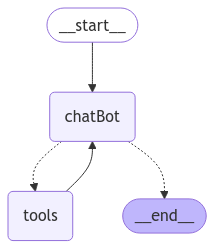

In [ ]:
from langgraph.checkpoint.memory import AsyncSqliteSaver

def get_runnable():
    # memory = MemorySaver()
    memory = AsyncSqliteSaver.from_conn_string(":memory:")
    graph_builder = StateGraph(State)
    graph_builder.add_node('chatBot', chatBot)
    tool_node = ToolNode(tools=tools)

    graph_builder.add_node('tools', tool_node)
    graph_builder.add_conditional_edges('chatBot', tools_condition)

    graph_builder.add_edge("tools", 'chatBot')
    graph_builder.set_entry_point('chatBot')

    graph = graph_builder.compile(checkpointer=memory)
    return graph


In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# graph.invoke({'messages': ['Tell me about earth in 3 points']})

config = {"configurable": {"thread_id": 1}}
output = graph.invoke({'messages': ['Tell me about earth in 3 points']}, config=config)
output

{'messages': [HumanMessage(content='Tell me about earth in 3 points', additional_kwargs={}, response_metadata={}, id='d78ec1f7-76bd-42f5-a8b8-69b785f65793'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-02-09T16:16:47.9618641Z', 'done': True, 'done_reason': 'stop', 'total_duration': 36015605700, 'load_duration': 15864391200, 'prompt_eval_count': 246, 'prompt_eval_duration': 6316000000, 'eval_count': 40, 'eval_duration': 13751000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-69dcce4a-b13b-4430-8967-9756030db29a-0', tool_calls=[{'name': 'webSearch', 'args': {'prompt': 'earth information'}, 'id': 'e90a2cb8-cd7b-423e-8088-30945cac568e', 'type': 'tool_call'}, {'name': 'llmSearch', 'args': {'prompt': 'Three key facts about Earth'}, 'id': 'f5054f0e-e3ae-4fe7-afeb-8f1a31a66403', 'type': 'tool_call'}], usage_metadata={'input_tokens': 246, 'output_tokens': 40, 'total_tokens': 286}),
  Tool

In [ ]:
config = {"configurable": {"thread_id": 1}}
while True:
    user_input = input("You: ")
    if user_input in ['exit', "quit", "q"]:
        print("Goodbye!")
        break
    output = graph.invoke({'messages': [user_input]}, config=config)
    output['messages'][-1].pretty_print()